
# The scope of this project is to familiarize with graph related techniques and apply them in multiple datasets.
Firstly, we want to test implemented and customized algorithms to karate club network in order to validate the results.
At the second phase we have identified 2 Use Cases to extract information for movies collection dataset.
In particular we want to:


1.   Connect Directors and Actors based on their collaboration and find cliques among them
2.   Connect Actors and Movies in weighted graph based on the revenue of the movie. In that way we can identify important nodes (Actors) that will eventually lead to a successful movie



In [0]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm,colors
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import scipy
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


Load and use karate club network
Link: [NetworkX karate club](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html
)

In [0]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G)


In [0]:
def draw_communities(G, y_actual, pos, title):
    """
    Function responsible to draw the nodes to a plot with assigned colors for each individual cluster
    Inputs
    ----------
    G : networkx graph
    y_actual : list with the ground truth
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    title : The title of the plot
    """ 
    fig, ax = plt.subplots(figsize=(16,9))
    
    # Convert y_actual list to a dict where key=cluster, value=list of nodes in the cluster
    key = defaultdict(list)
    for node, value in enumerate(y_actual):
        key[value].append(node)
    
    # Normalize number of clusters for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(key.keys()))
    
    for cluster, members in key.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(cluster)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    plt.title(title)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

In [0]:
# True labels of the group each student (node) unded up in. Found via the original paper
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

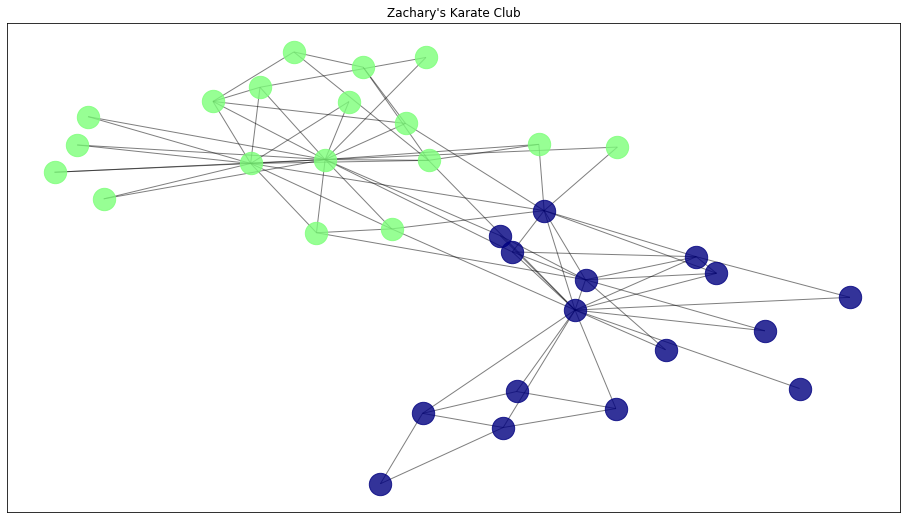

In [234]:
draw_communities(G, y_true, pos, "Zachary's Karate Club")

In [0]:
def graph_to_edge_matrix(G):
    """
    Convert a networkx graph into an edge matrix.
    Inputs: 
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_mat[node][neighbor] = 1
        edge_mat[node][node] = 1

    return edge_mat

In [236]:
edge_mat = graph_to_edge_matrix(G)
edge_mat

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [0]:
def laplacian(A):
    """
    Computes the symetric normalized laplacian.
    L = D^{-1/2} A D{-1/2}
    Inputs: 
    ----------
    A : Affinity or Adj matrix
    """
    D = np.zeros(A.shape)
    w = np.sum(A, axis=0)
    D.flat[::len(w) + 1] = w ** (-0.5)  # set the diag of D to w
    return D.dot(A).dot(D)

def k_means(X, n_clusters):
    """
    Computes KMeans clustering algorithm.
    Inputs: 
    ----------
    X : array-like or sparse matrix, shape=(n_samples, n_features)
    n_clusters : The number of clusters
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=1231)
    return kmeans.fit(X).labels_

def spectral_clustering(affinity, n_clusters, cluster_method=k_means):
    """
    Calculates Spectral Clustering
    Inputs: 
    ----------
    affinity : Affinity or Adj matrix
    n_clusters : The number of clusters
    cluster_method : Default usage of kMeans
    """
    L = laplacian(affinity)
    eig_val, eig_vect = scipy.sparse.linalg.eigs(L, n_clusters)
    X = eig_vect.real
    rows_norm = np.linalg.norm(X, axis=1, ord=2)
    Y = (X.T / rows_norm).T
    labels = cluster_method(Y, n_clusters)
    return labels

**Train and Fit Sklearn SC and our implementation**

In [0]:
k_clusters = 2
sc = cluster.SpectralClustering(n_clusters=k_clusters, affinity="precomputed", n_init=200)
results = sc.fit(edge_mat)

custom_SC_results = spectral_clustering(edge_mat, k_clusters)

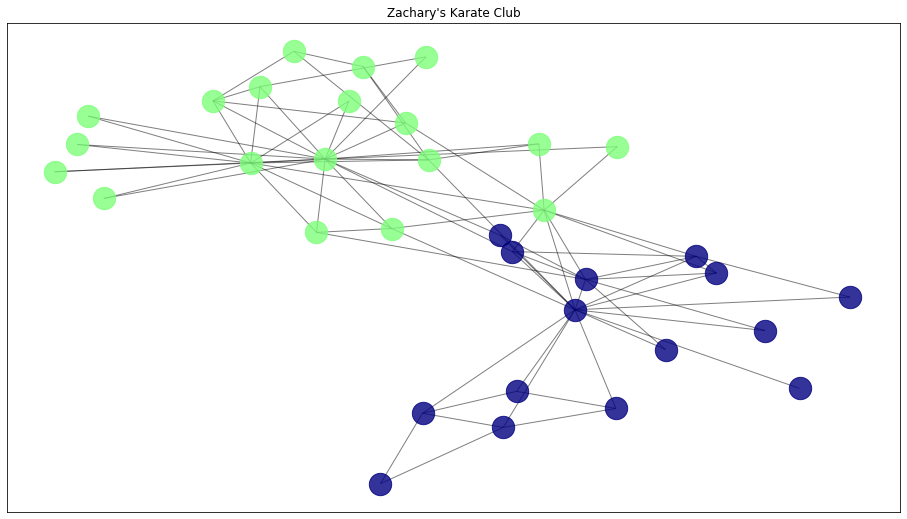

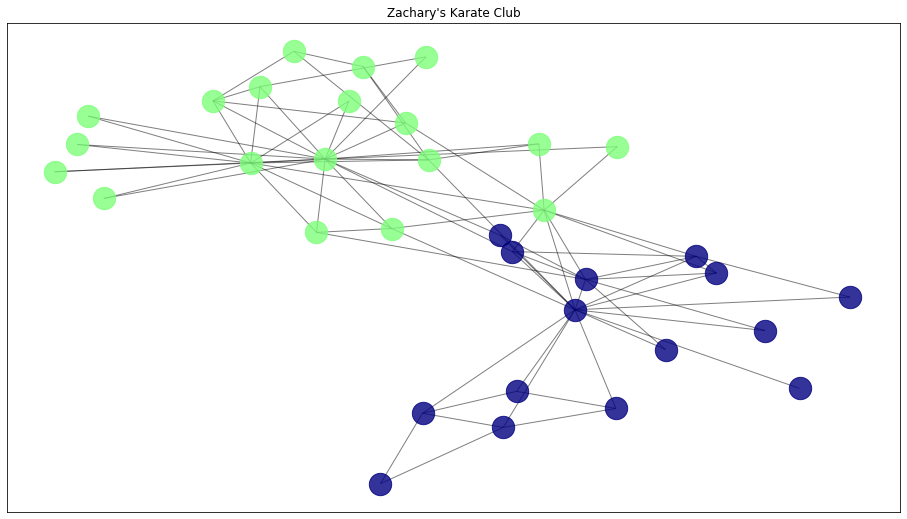

In [239]:
draw_communities(G, results.labels_, pos, "Zachary's Karate Club")
draw_communities(G, custom_SC_results, pos, "Zachary's Karate Club")

In [240]:
nmi_results = []
ars_results = []
y_true

y_true_val = list(y_true)

# Append the results into lists
nmi_results.append(normalized_mutual_info_score(y_true_val, results.labels_))
ars_results.append(adjusted_rand_score(y_true_val, results.labels_))
nmi_results.append(normalized_mutual_info_score(y_true_val, custom_SC_results))
ars_results.append(adjusted_rand_score(y_true_val, custom_SC_results))
print("NMI: " + str(nmi_results))
print("ARS: " + str(ars_results))

NMI: [0.8364981174679549, 0.8364981174679549]
ARS: [0.882302454654689, 0.882302454654689]


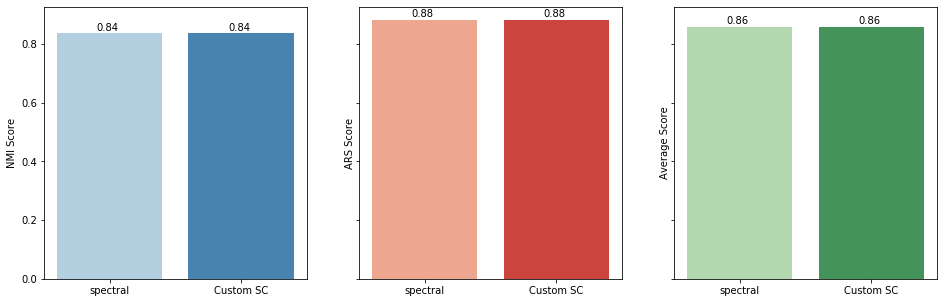

In [241]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

x = np.arange(2)
avg = [sum(x) / 2 for x in zip(nmi_results, ars_results)]

xlabels = list(['spectral','Custom SC'])

sns.barplot(x, nmi_results, palette='Blues', ax=ax1)
sns.barplot(x, ars_results, palette='Reds', ax=ax2)
sns.barplot(x, avg, palette='Greens', ax=ax3)

ax1.set_ylabel('NMI Score')
ax2.set_ylabel('ARS Score')
ax3.set_ylabel('Average Score')

# # Add the xlabels to the chart
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax3.set_xticklabels(xlabels)

# Add the actual value on top of each bar
for i, v in enumerate(zip(nmi_results, ars_results, avg)):
    ax1.text(i - 0.1, v[0] + 0.01, str(round(v[0], 2)))
    ax2.text(i - 0.1, v[1] + 0.01, str(round(v[1], 2)))
    ax3.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))

# Show the final plot
plt.show()


In [0]:
def draw_true_vs_pred(G, y_true, y_pred, pos, algo_name, ax):
    
    for val in range(len(y_true)):
        if y_pred is not None:
            if y_true[val] == y_pred[val]:
                node_color = [0, 1, 0]
                node_shape = 'o'
            else:
                node_color = [0, 0, 0]
                node_shape = 'X'
                
        nx.draw_networkx_nodes(G, pos,
                               nodelist=[val],
                               node_color=node_color,
                               node_size=250,
                               alpha=0.7,
                               ax=ax,
                               node_shape=node_shape)
    
    # Draw edges and show final plot
    ax.set_title(algo_name)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

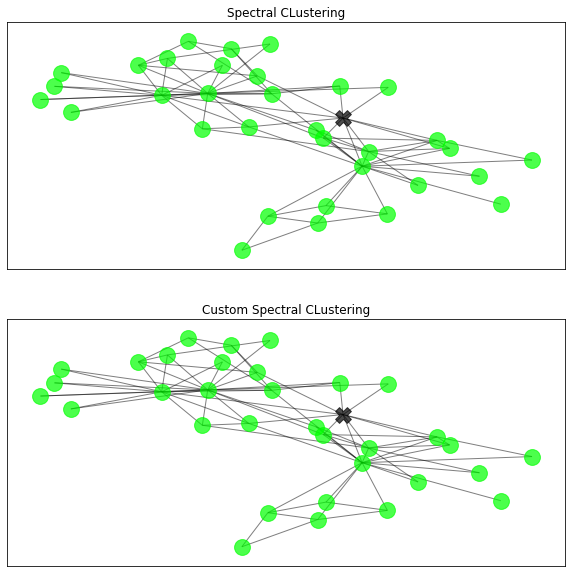

In [243]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 10))
draw_true_vs_pred(G, y_true, results.labels_, pos, 'Spectral CLustering', ax1)
draw_true_vs_pred(G, y_true, custom_SC_results, pos, 'Custom Spectral CLustering', ax2)